In [1]:
# Patient details file yaml/json
import yaml
from datetime import datetime, timedelta


import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('png', 'pdf')

import seaborn as sns
plt.rcParams['lines.linewidth'] = 0.75

import numpy as np
import pandas as pd
def df_repr_latex(self):
    return '\n'.join([
        r'\vspace{5mm}',
        r'{\scriptsize{\centering{%s}}}' % self.to_latex(),
        r'\vspace{5mm}'
    ])
pd.DataFrame._repr_latex_ = df_repr_latex
from pandas.io.formats.style import Styler
Styler._repr_latex_ = lambda s: s.data._repr_latex_()

class HTMLLatex:
    def __init__(self, html, latex):
        self.html = html
        self.latex = latex
    def _repr_html_(self): return self.html
    def _repr_latex_(self): return self.latex
NewPage = HTMLLatex('<hr>', r'\clearpage\newpage')

from IPython.display import display, HTML, Latex

from dcmfetch import fetch_series
from mriqa.reports import (
    ghosting_report, slice_profile_report, piqt_distortion_report,
    uniformity_report, snr_report, snr_report_multi, svs_report, fid_report,
    phase_background_report, fbirn_full_report, mtf_report
)
from mriqa.phantoms import SIEMENSSHORTBOTTLE, PIQTSP
from mriqa.tools import show_montage, watermark
from mriqa.dcmio import qa_date, scanner_operator, larmor_frequency
from mriqa.xmlqa.coilqa import (
    find_qa_results_file,
    coil_snr, coil_snr_history, coil_name, coil_names,
    plot_coil_images, 
    MINCOILSERNO
)

from dcmextras.siemenscsa import csa, phoenix

# Percent above specification
MARGIN = 5 
margin_colour = lambda x: 'color: %s' % ('green' if x>= MARGIN else 'orange' if x>0 else 'red')
ok_colour     = lambda x: 'color: %s' % ('green' if x else 'red')

# -- Watermark ---
wm = watermark()
display(
    pd.DataFrame(
        {'Watermark': list(wm.values())},
        index=wm.keys())
)

Watermark
CalculationTime  2021-01-04T13:09:03+00:00
User                    birchhub/elberthol
PythonVersion                CPython 3.7.9
Platform           Linux 4.15.0-76-generic
mriqa                                0.2.8
dcmextras                            0.2.6
pydicom                              2.1.0
scipy                                1.5.2
numpy                               1.19.2
skimage                             0.17.2
matplotlib                           3.3.2

### Details of series to analyse.
The Patient ID, the Study ID and the Series Numbers of the QA scans.

In [2]:
with open('study.yml') as fp:
    study_info = yaml.safe_load(fp)

patid, studyid = study_info['PatID'], study_info.get('StudyID', '1')
tests = study_info['Tests']
for k, test in tests.items():
    if 'PatID' not in test:
        test['PatID'] = patid
    if 'StudyID' not in test:
        test['StudyID'] = studyid

series = tests['SliceProfile_PIQT']['Series']['3mm']

d = fetch_series(patid, studyid, sernos=series)[0]
scanner, date_of_scan, operator = d.StationName, qa_date(d), scanner_operator(d, 'BIRCH')
display(
    pd.DataFrame(
        {'Details':[scanner, date_of_scan, patid, studyid]}, 
        index=['Scanner', 'Date', 'Patient', 'Study']
    )
)

Details
Scanner          MRC27202
Date             20200804
Patient  AQA20200804BHIAV
Study                   1

# Summary
Tests Performed:

- Slice shape and Profile
- Distortion and Field of View
- Resolution
- Ghosting
- Head Coil SNR
- Head Coil Image Uniformity
- PC flow bias

All of the above are acceptable.

----

### Recommended Actions

No actions necessary.

In [3]:
aqadate = (datetime.strptime(date_of_scan, '%Y%m%d') + timedelta(days=365)).strftime('%B %Y')

text = f'''
This machine is next due for Annual QA tests in {aqadate}.
'''

HTMLLatex(text, text)

----

In [4]:
text = f'''
BIRCH
Medical Physics & Bioengineering, UHBW
{datetime.strptime(date_of_scan, '%Y%m%d').strftime('%B %Y')}
'''

HTMLLatex(
    f'<pre>{text}</pre>',
    '\n'.join([
        r'\vfill',
        '\n',
        r'\begin{verbatim}',
        text,
        r'\end{verbatim}'
    ])
)

In [5]:
NewPage

# Detailed Results

## Slice Profile

These are the profiles of 3mm and 5mm slices in an axial slice of a conventional spin echo using the PIQT slice profile block.

### 3 mm Slice

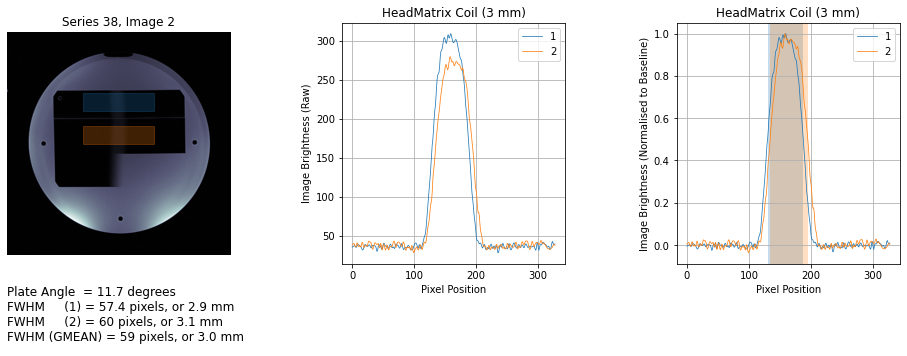

In [6]:
# TO2: Slice 3mm
info = tests['SliceProfile_PIQT']
series, slice_idx = info['Series']['3mm'], info['Slice']['3mm']

# Distortion Corrected, Phase RL, Non-Uniformity Corrected 512*512
dobjs = fetch_series(patid, studyid, sernos=series)
results = slice_profile_report(dobjs[slice_idx], phantom=PIQTSP, flipped_ud=False, flipped_rl=False)

### 5 mm Slice

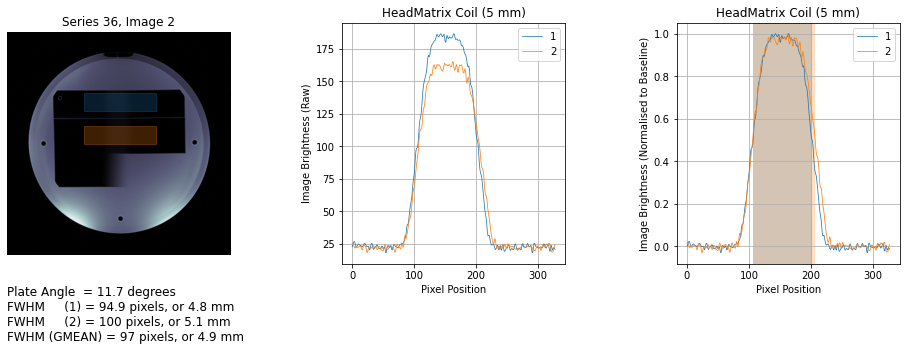

In [7]:
# TO2: Slice 5mm
# Distortion Corrected, Phase RL, Non-Uniformity Corrected 512*512
info = tests['SliceProfile_PIQT']
series, slice_isx = info['Series']['5mm'], info['Slice']['5mm']
dobjs = fetch_series(patid, studyid, sernos=series)
result = slice_profile_report(dobjs[slice_idx], phantom=PIQTSP, flipped_ud=False, flipped_rl=False)
results = results.append(result)

In [8]:
pd.set_option('precision', 1)
results[['FWHMGMeanPixels', 'FWHMGMeanMM']].rename(columns={
    'FWHMGMeanPixels': 'Projected FWHM (pixels)',
    'FWHMGMeanMM': 'True FWHM (mm)'
})

Projected FWHM (pixels)  True FWHM (mm)
SliceThickness                                         
3.0                                59.1             3.0
5.0                                97.7             4.9

These are both rather rounded profiles as seen on other Siemens scanners with this protocol. The profile widths, though, are well within the AAPM tolerance of 0.5mm.

In [9]:
NewPage

## Image Scaling and Geometric Distortion

The PIQT phantom has a grid of objects for scale and distortion measurements in plane. These results are from an axial slice acquired with a conventional spin echo after applying Siemens 2D distortion correction. The scale reflects the Gradient Sensitivity calibration performed by the manufacturer as part of the system installation. 

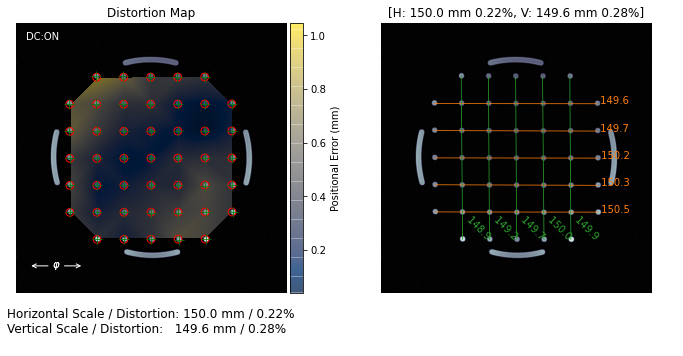

In [10]:
# PIQT: Distortion
info = tests['Distortion_PIQT']
patid, studyid = info['PatID'], info['StudyID']
series, slices = info['Series'], info['Slice']

# SE: Axial, Phase RL, 512 matrix
dobj = fetch_series(patid, studyid, sernos=series['AxialRL_Corrected'])[slices['AxialRL_Corrected']]
results = piqt_distortion_report(dobj)

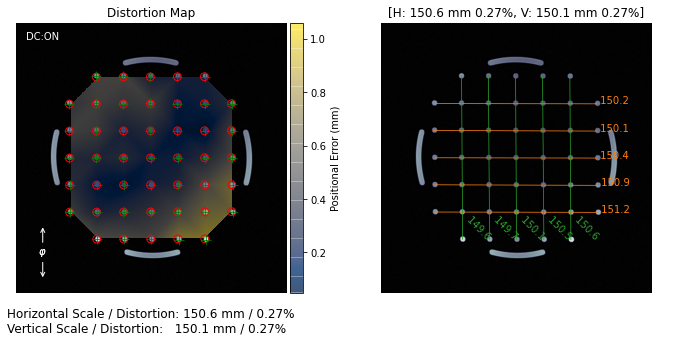

In [11]:
# PIQT: Distortion
# SE: Axial, Phase AP, 512 matrix
dobj = fetch_series(patid, studyid, sernos=series['AxialAP_Corrected'])[slices['AxialAP_Corrected']]
results = results.append(piqt_distortion_report(dobj))

In [12]:
pd.set_option('precision', 2)
results[[
   'PhaseDirection', 'Sensitivity',
    'HorizontalScale', 'HorizontalDistortion',
    'VerticalScale', 'VerticalDistortion'
]].rename(columns={
    'PhaseDirection': 'Phase Direction',
    'HorizontalScale': 'Horizontal Scale (mm)', 'HorizontalDistortion':'Horizontal Distortion (%)',
    'VerticalScale': 'Vertical Scale (mm)', 'VerticalDistortion': 'Vertical Distortion (%)'  
})

Phase Direction  Sensitivity  Horizontal Scale (mm)  \
Series                                                       
38                  RL         0.24                 150.04   
40                  AP         0.24                 150.59   

        Horizontal Distortion (%)  Vertical Scale (mm)  \
Series                                                   
38                           0.22               149.58   
40                           0.27               150.10   

        Vertical Distortion (%)  
Series                           
38                         0.28  
40                         0.27

The scale in both the RL and AP directions are well within 1% at the bandwidth used (130Hz/pixel).

In [13]:
NewPage

## Resolution

Image resolution is estimated by analysis of the MTF block in the PIQT phantom. These results are from an axial slice acquired using a conventional spin echo.

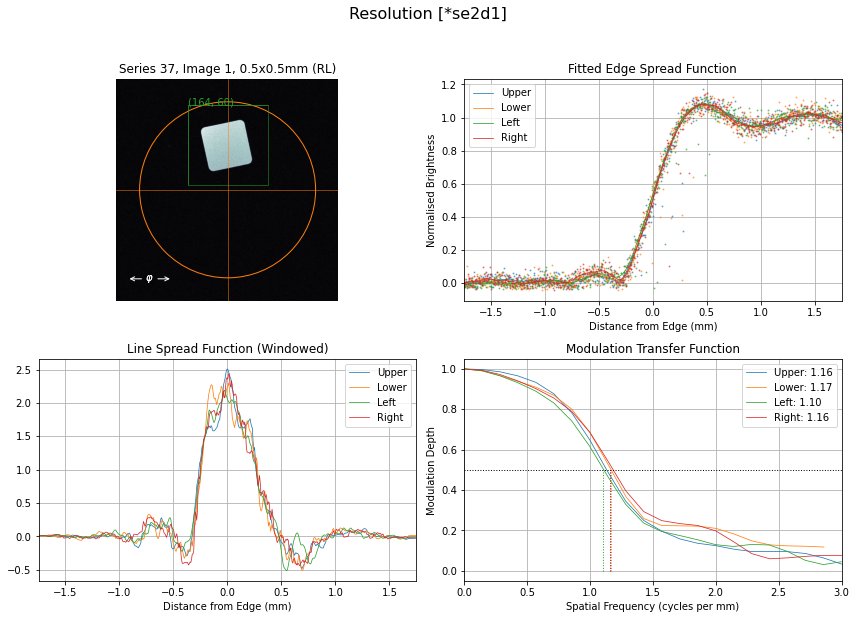

MTF_50
Upper    1.16
Lower    1.17
Left     1.10
Right    1.16

In [14]:
# PIQT: Resoution/MTF
info = tests['Resolution_PIQT']
patid, studyid = info['PatID'], info['StudyID']
series, slices = info['Series'], info['Slice']

# SE: Axial, Phase RL, 512 matrix
dobjs = sorted(fetch_series(patid, studyid, sernos=[series['SE512']]), key=lambda d: int(d.InstanceNumber))
dobj_mtf, dobj_centre = dobjs[slices['MTF']], dobjs[slices['Centre']]

results = mtf_report(dobj_mtf, dobj_centre)
plt.show()
results

The MTF_50 is consistent with the nominal image resolution of 0.5 x 0.5 mm.

In [15]:
NewPage

## Ghosting

Image ghosting following the approach of [AAPM report 100](https://www.aapm.org/pubs/reports/RPT_100.pdf) for the axial orientation with RL and AP phase encoding directions and four example sequences.

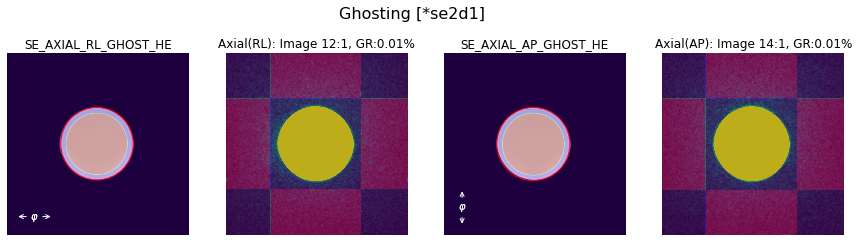

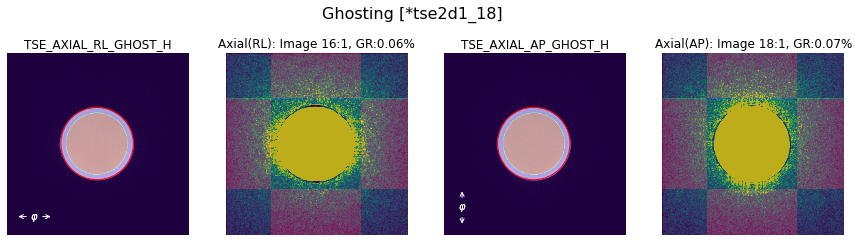

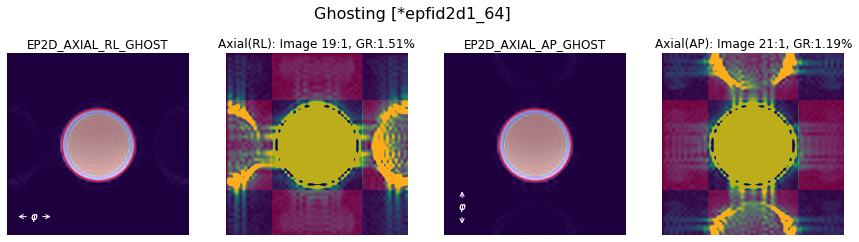

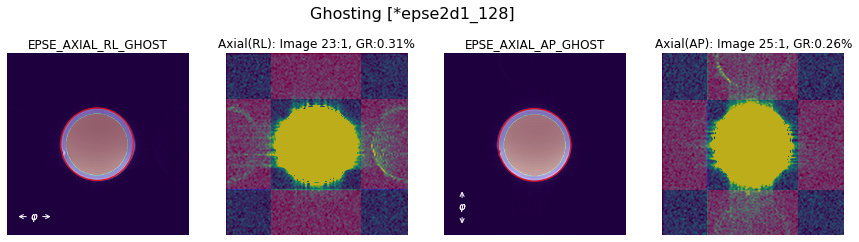

Sequence Orientation Phase Direction  Ghost Ratio (%)
Series                                                           
12            *se2d1       Axial              RL            0.006
14            *se2d1       Axial              AP            0.008
16        *tse2d1_18       Axial              RL            0.058
18        *tse2d1_18       Axial              AP            0.065
19      *epfid2d1_64       Axial              RL            1.510
21      *epfid2d1_64       Axial              AP            1.190
23      *epse2d1_128       Axial              RL            0.310
25      *epse2d1_128       Axial              AP            0.261

In [16]:
# GE10CM: Ghosting
info = tests['Ghosting_GE10']
patid, stuid = info['PatID'], info['StudyID']
series = info['Series']

# SE Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in series['SE']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = ghosting_report(dobjs, axes=list(axs.flat))

# TSE18 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in series['TSE']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))

# EPI64 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in series['EP2D']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))
plt.show()

# EPISE128 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in series['EPSE']]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))
plt.show()

with pd.option_context('display.precision', 3):
    display(
        results[['Sequence', 'Orientation', 'PhaseDirection', 'GhostRatio']].rename(columns={
            'PhaseDirection': 'Phase Direction', 'GhostRatio': 'Ghost Ratio (%)'
        })
    )

The level of ghosting is low (less than 1%) for SE, TSE, and SE-EPI. The GRE EPI ghosting is above 1% though for both read-out directions. These are slighltly worse than the results at the previous annual assessment. 

In [17]:
NewPage

## Receiver Coil Uniformity

We have tested the uniformity of the head coil in all three planes using a spherical phantom filled with silicone oil. Results are presented both before and after `prescan-normalize` intensity correction.

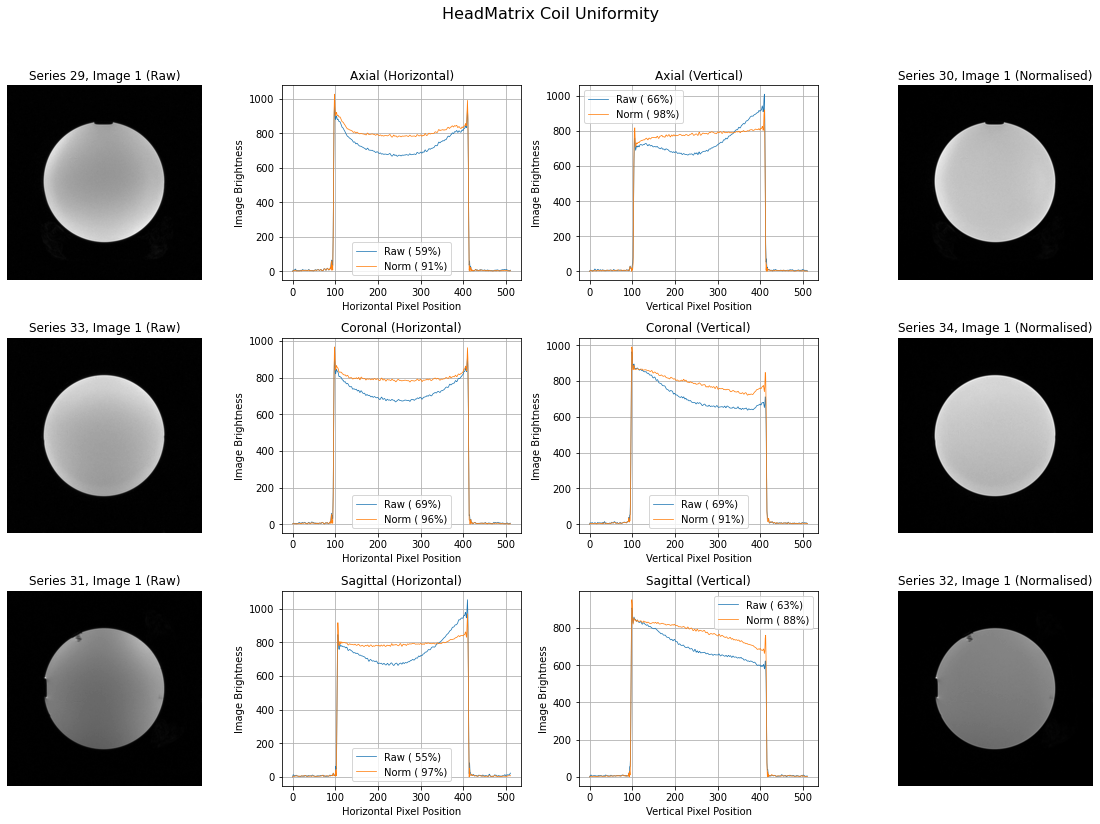

Raw Images


Series No.                           Protocol         Axis  \
Orientation                                                               
Axial                29  SE_AXIAL_RL_SNR_UNIF_HEAD_OIL20CM     Axial/RL   
Coronal              33        SE_COR_FH_UNIF_HEAD_OIL20CM   Coronal/HF   
Sagittal             31        SE_SAG_AP_UNIF_HEAD_OIL20CM  Sagittal/AP   

              X Uniformity (%)  Y Uniformity (%)  
Orientation                                       
Axial                    58.93             66.45  
Coronal                  68.65             68.97  
Sagittal                 54.52             63.32

Intensity Normalised Images


Series No.                           Protocol         Axis  \
Orientation                                                               
Axial                30  SE_AXIAL_RL_SNR_UNIF_HEAD_OIL20CM     Axial/RL   
Coronal              34        SE_COR_FH_UNIF_HEAD_OIL20CM   Coronal/HF   
Sagittal             32        SE_SAG_AP_UNIF_HEAD_OIL20CM  Sagittal/AP   

              X Uniformity (%)  Y Uniformity (%)  
Orientation                                       
Axial                    90.91             98.06  
Coronal                  95.91             90.60  
Sagittal                 97.10             87.77

In [18]:
# OILSPHERE: Uniformity
# SE Axial,Coronal,Sagittal; w w/o Intensity Normalization
info = tests['Uniformity_Oil']
patid, stuid = info['PatID'], info['StudyID']
series = info['Series']

raw_tra = fetch_series(patid, stuid, sernos=series['Axial'][0])
psn_tra = fetch_series(patid, stuid, sernos=series['Axial'][1])
raw_sag = fetch_series(patid, stuid, sernos=series['Sagittal'][0])
psn_sag = fetch_series(patid, stuid, sernos=series['Sagittal'][1])
raw_cor = fetch_series(patid, stuid, sernos=series['Coronal'][0])
psn_cor = fetch_series(patid, stuid, sernos=series['Coronal'][1])

if len(raw_tra) > 1:
    results = uniformity_report(
        raw_dobjs=[raw_tra[0], raw_sag[0], raw_cor[0]],
        psn_dobjs=[psn_tra[0], psn_sag[0], psn_cor[0]],
        raw_dobjsb=[raw_tra[1], raw_sag[1], raw_cor[1]],
        psn_dobjsb=[psn_tra[1], psn_sag[1], psn_cor[1]]
    )
else:
    results = uniformity_report(
        raw_dobjs=[raw_tra[0], raw_sag[0], raw_cor[0]],
        psn_dobjs=[psn_tra[0], psn_sag[0], psn_cor[0]],
    )

plt.show()

with pd.option_context('display.precision', 2):
    print('Raw Images')
    display(
        results[['SeriesRaw',  'ProtocolRaw',  'OrientRaw', 'XUniformityRaw', 'YUniformityRaw']].rename(columns={
            'SeriesRaw': 'Series No.', 'ProtocolRaw': 'Protocol', 'OrientRaw': 'Axis',
            'XUniformityRaw': ' X Uniformity (%)', 'YUniformityRaw': 'Y Uniformity (%)'
        })
    )
    print('Intensity Normalised Images')
    display(
        results[['SeriesNorm', 'ProtocolNorm', 'OrientNorm', 'XUniformityNorm', 'YUniformityNorm']].rename(columns={
            'SeriesNorm': 'Series No.', 'ProtocolNorm': 'Protocol', 'OrientNorm': 'Axis',
            'XUniformityNorm': ' X Uniformity (%)', 'YUniformityNorm': 'Y Uniformity (%)'
        })
    )

As expected for a multi-element coil the uncorrected images are significantly non-uniform. In general, the Siemens `prescan-normalize` intensity correction is adequate in compensating for this, but the residual non-uniformity is rather greater along the bore.

In [19]:
NewPage

## Signal to Noise

The Siemens QA involves a full element by element assessment of the SNR of all the coils. For reference purposes the following is an independent estimate for the standard head/neck coil using the Siemens long bottle phantom. The SNR is estimated over centred discs with diameters 50% and 75% of the phantom. The signal is taken from a region within the phantom in the mean of two images and the noise is estimated from a background region in their difference image.

### 12 Channel Head Coil

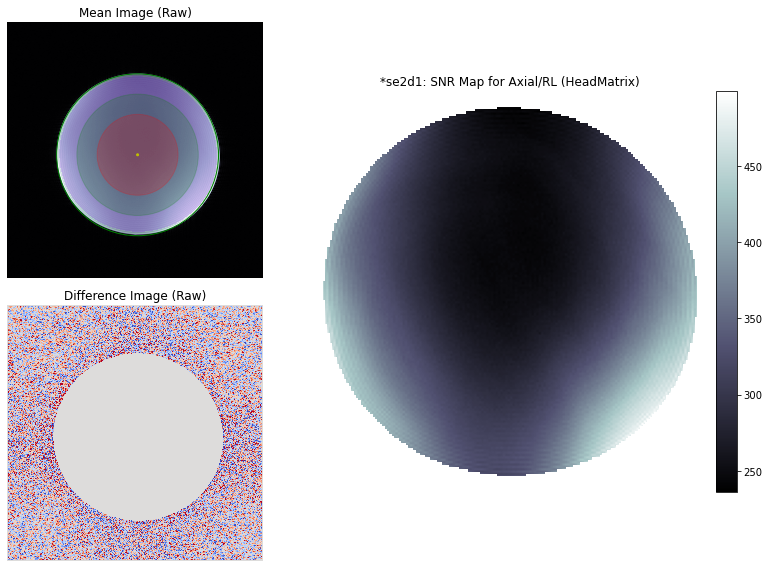

SNR: Raw Images


HeadMatrix
RegionSize            
0.50             266.0
0.75             290.0

In [20]:
# LONGBOTTLE: Signal to Noise
info = tests['QuarterlySNR']
patid, stuid = info['PatID'], info['StudyID']
series = info['Series']

raw_tra = fetch_series(patid, stuid, sernos=series['Signal_Combined'])
if len(raw_tra) > 1:
    results = snr_report(raw_dobjs=[raw_tra[0]], raw_dobjsb=[raw_tra[1]], phantom=SIEMENSSHORTBOTTLE)
else:
    results = snr_report(raw_dobjs=[raw_tra[0]], phantom=SIEMENSSHORTBOTTLE)
plt.show()

print('SNR: Raw Images')
with pd.option_context('display.precision', 2):
    display(np.round(results))

These results are similar to those we have obtained on other 1.5T Siemens scanners under these conditions.

In [21]:
NewPage

### Single-element Images
This is the SNR calculated from individual element images combined as a sum of squares. This is the methodology used in the quarterly QA.

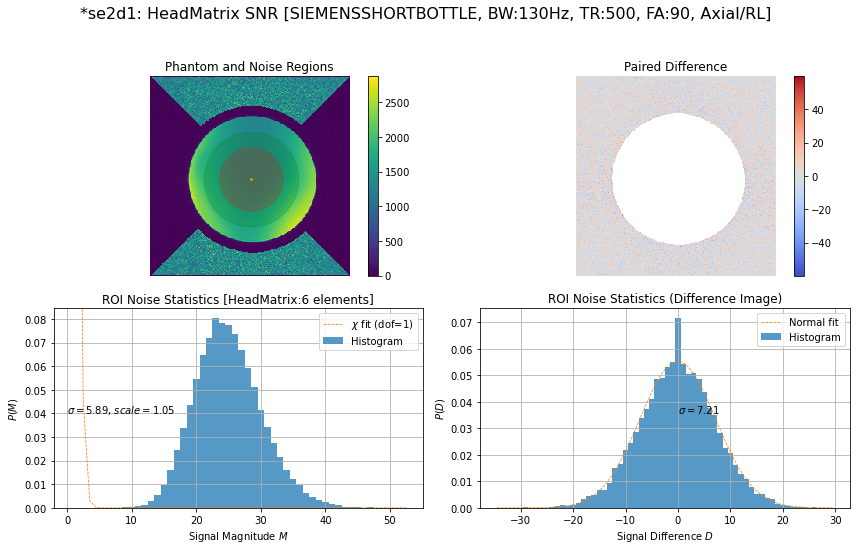

HeadMatrix
0.50      280.92
0.75      305.71

In [22]:
# SNR (uncombined channels)
from mriqa.dcmio import coil_elements
dobjs = sorted(
    fetch_series(patid, stuid, series['Signal']),
    key=lambda x: (int(x.SeriesNumber), int(x.AcquisitionNumber), coil_elements(x)[0])
)
nchannels = len(set(coil_elements(d)[0] for d in dobjs))
dobjsa, dobjsb = dobjs[:nchannels], dobjs[nchannels:]

with pd.option_context('display.precision', 2):
    display(snr_report_multi(dobjsa, dobjsb, phantom=SIEMENSSHORTBOTTLE))

The artefact in the difference image histogram may be due to distortion correction having been applied to the coil element images. The values are consistent with previous results from this scanner and similar to those we have obtained on other 1.5T Siemens scanners under these conditions.

In [23]:
NewPage

## Phase Contrast Velocity Offsets

These are cardiac gated flow encoded acquisitions of a large gel phantom with slice orientations representative of aortic and pulmonary artery studies. The acquistions are repeated at different displacements along the bore of the scanner. The plots shows the baseline velocity error over the volume of the phantom in cm/s.

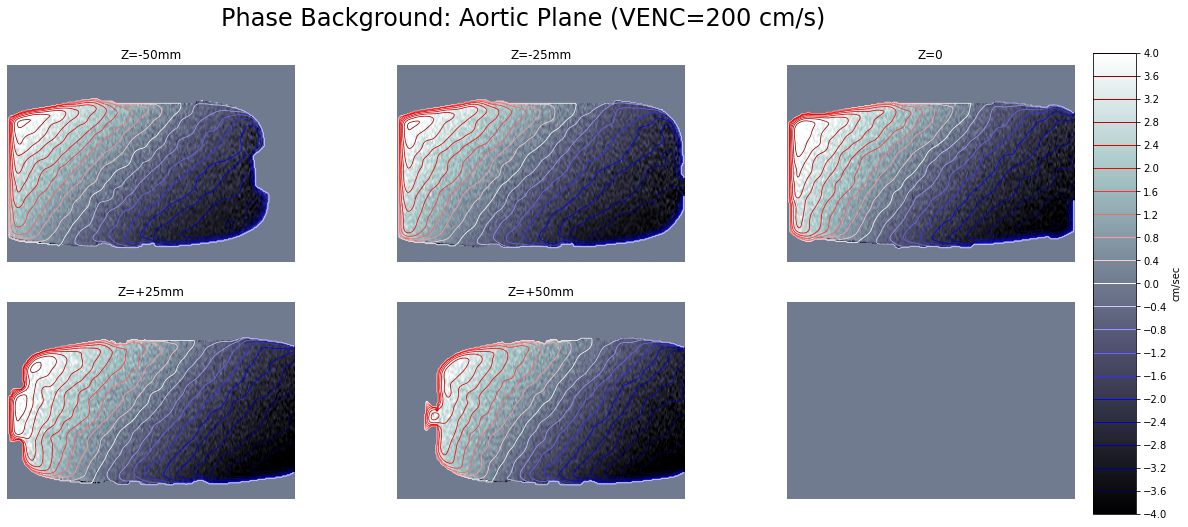

In [24]:
# Gerry Can Phantom: PC flow zero velocity
info = tests['PCFlowBias']
patid, studyid = info['PatID'], info['StudyID']
magnitude_series = info['Series']['AP_Magnitude']
phase_series = info['Series']['AP_Phase']
dobjs_magnitude = fetch_series(patid, studyid, sernos=magnitude_series)
dobjs_phase = fetch_series(patid, studyid, sernos=phase_series)
results = phase_background_report(dobjs_magnitude, dobjs_phase, plane='Aortic', transpose=True)

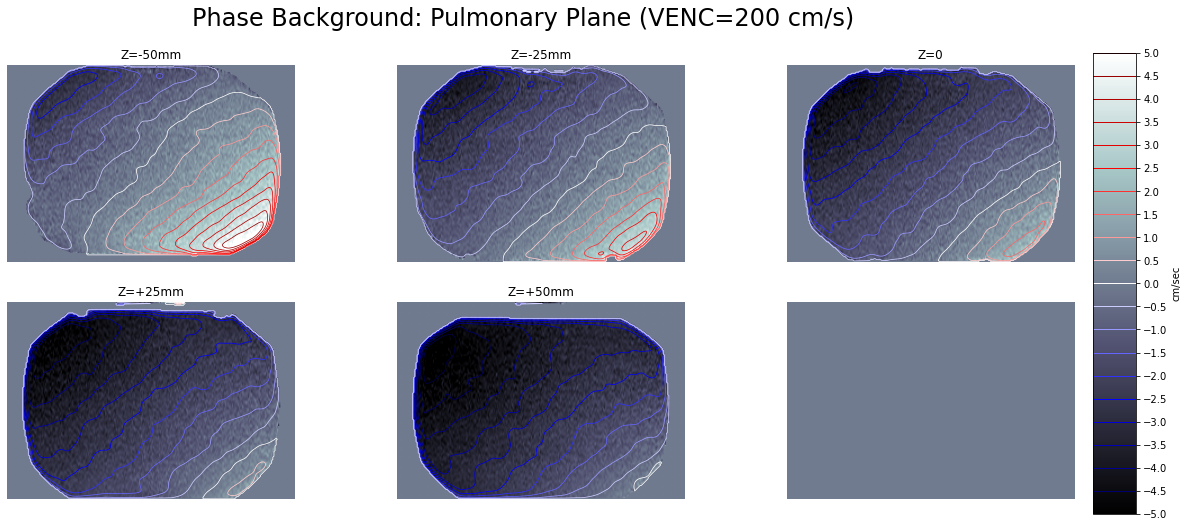

Sequence         Protocol   Venc  MaxPositiveError  \
Plane                                                                
Aortic     *fl2d1_v200in     AorticPlaneZ  200.0              7.41   
Pulmonary  *fl2d1_v200in  PulmonaryPlaneZ  200.0              8.57   

           MaxNegativeError  
Plane                        
Aortic               -10.45  
Pulmonary            -11.59

In [25]:
# Gerry Can Phantom: PC flow zero velocity
info = tests['PCFlowBias']
patid, studyid = info['PatID'], info['StudyID']
magnitude_series = info['Series']['PP_Magnitude']
phase_series = info['Series']['PP_Phase']
dobjs_magnitude = fetch_series(patid, studyid, sernos=magnitude_series)
dobjs_phase = fetch_series(patid, studyid, sernos=phase_series)
results = results.append(phase_background_report(dobjs_magnitude, dobjs_phase, plane='Pulmonary'))
plt.show()
results

Errors of the order of 5-6 cm/s are to be expected in cardiac flow measurement unless this background is allowed for.
The errors increase strongly away from the magnet isocentre.
Although there are point measurements that are higher, within the body of the phantom the maximum errors are within the expected range. These results are similar to those at the previous annual assessment (second visit).

In [26]:
NewPage

### Frequency Reference and Transmitter Voltage
These are the reference values reported in the DICOM header of a localizer scan.

In [27]:
# Siemens Long Bottle: localizer
info = tests['TuneupParams']
patid, studyid = info['PatID'], info['StudyID']
series = info['Series']
dobj = fetch_series(patid, studyid, sernos=series)[0]

csa_tags = csa(dobj)
phoenix_tags = phoenix(dobj)

pd.DataFrame({
    'ImagingFrequency': [float(larmor_frequency(dobj))],
    'TransmitterCalibration': [float(csa_tags['TransmitterCalibration'])],
    'TalesReferencePower': [float(csa_tags['TalesReferencePower'])],
    'GradientSensitivityX': [
        float(phoenix_tags['sGRADSPEC.flSensitivityX']) * 1e6,
    ],
    'GradientSensitivityY': [
        float(phoenix_tags['sGRADSPEC.flSensitivityY']) * 1e6,
    ],
    'GradientSensitivityZ': [
        float(phoenix_tags['sGRADSPEC.flSensitivityZ']) * 1e6
    ]
}, index=['Value']).T

Value
ImagingFrequency         63.68
TransmitterCalibration  213.84
TalesReferencePower     532.29
GradientSensitivityX     78.60
GradientSensitivityY     78.45
GradientSensitivityZ     91.02